# Rice Leaf Diseases Dataset Exploratory Data Analysis
This notebook will explore the [Rice Leaf Diseases dataset from Kaggle](https://www.kaggle.com/vbookshelf/rice-leaf-diseases).

## Setting up your environment
Before running this notebook, you will need to make sure you have [downloaded](https://www.kaggle.com/vbookshelf/rice-leaf-diseases) the dataset and extracted the files.  This notebook assumes the image data is extracted in the same directory as this notebook, and that the top-level data directory is named "rice_leaf_diseases".  You can edit the code if those assumptions do not hold on your own setup.

## Python Environment
You will need the following packages installed to execute the code shown in this notebook:

* [Matplotlib](https://matplotlib.org/)
* [Numpy](https://numpy.org/)
* [Pandas](https://pandas.pydata.org/)
* [Pillow](https://pillow.readthedocs.io/en/stable/)
* [Scikit-Learn](https://scikit-learn.org/)

In [1]:
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.metrics as metrics
%matplotlib inline

First, take a look at the directory structure of the images.  You should see the following directory structure:

    rice_leaf_diseases/
        Bacterial leaf blight/
        Brown spot/
        Leaf smut/

There is no "ground truth" file for this dataset -- the ground truth is actually specified by the directory structure itself.  To make things a bit easier, we will build a CSV file that will link the file paths to the ground truth class.  This will come in handy later.

In [2]:
# This section sets up path information so we can easily locate the files for each class.
data_directory = 'rice_leaf_diseases'
image_classes = ['leaf_blight', 'brown_spot', 'leaf_smut']
image_directories_by_class = {
    'leaf_blight': 'Bacterial leaf blight',
    'brown_spot': 'Brown spot',
    'leaf_smut': 'Leaf smut'
}

In [3]:
# Now, we can read the file list for each class into lists.  
# Those can be added to a table and saved to a CSV file for later use.
ground_truth_rows = []
for class_name in image_classes:
    file_list = os.listdir(os.path.join(data_directory, image_directories_by_class[class_name]))
    # Pre-pend the directory path information to the file name and create a row with class, path:
    for image_name in file_list:
        ground_truth_rows.append({'class': class_name, 'image_path': os.path.join(data_directory, image_directories_by_class[class_name], image_name)})
ground_truth_df = pd.DataFrame.from_dict(ground_truth_rows)

In [4]:
# Let's take a look:
ground_truth_df.head()

,class,image_path
0,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
1,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
2,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
3,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...
4,leaf_blight,rice_leaf_diseases/Bacterial leaf blight/DSC_0...


In [5]:
# And save the ground truth to a CSV:
ground_truth_df.to_csv('rice_leaf_diseases_ground_truth.csv', index=False)

Now that we've generated a ground truth file for later, let's actually have a look at the images themselves.

First, let's just use `matplotlib`'s `pyplot` library to both load and display the images.  This example uses a 3x3 grid with axis labels (the technique for labels comes from [this StackOverflow answer](https://stackoverflow.com/a/25814386)).

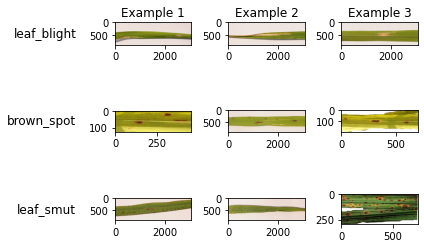

In [6]:
# Let's visualize a few from each category:
fig, axes = plt.subplots(3, 3)
pad = 5
for ax, col in zip(axes[0], ['Example 1', 'Example 2', 'Example 3']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], image_classes):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for cls_idx, class_name in enumerate(image_classes):
    examples = ground_truth_df[ground_truth_df['class'] == class_name]['image_path'].sample(n=3).values
    for img_idx, example in enumerate(examples):
        example_img = plt.imread(example)
        axes[cls_idx, img_idx].imshow(example_img)


fig.tight_layout()
plt.show()


Now we have some idea of what we are working with.  Notice that the images may not all be the same size... (If they do look the same size, try re-running the cell to get a different random sample).

This technique is fine for visualization, but to train a model we will need to keep the images in memory.  

There is more than one way to do this in Python... The `scikit-image` library supports image loading and manipulation, the "PIL" (Python Imaging Library, called `pillow` in the pypi package index) is also great for this.  We will use PIL (via `pillow`) here.

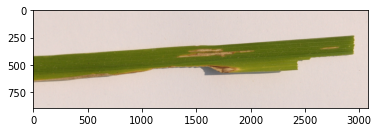

In [7]:
# Example of loading up a single image. First, get a random image's path.
example_image_path = os.path.join(data_directory, 'Bacterial leaf blight/DSC_0365.JPG')
# Now, load the image itself with PIL:
example_image = PIL.Image.open(example_image_path)
# We can view it with Matplotlib's `imshow` just like we did in the grid above:
plt.imshow(example_image)

Now that we have the image loaded, we can convert it to a Numpy array like this:

In [8]:
example_image_arr = np.asarray(example_image)
# Show the shape of the Numpy array:
print(example_image_arr.shape)

(897, 3081, 3)


You can see that this image has a shape of 3081x897.  Note that Numpy shows rows first, so the 897 is the height of the image in pixels; we often talk about the width first, so the first two numbers are reversed in the previous sentence.  The third number indicates the number of "color channels" the image has.  Most images will have 3 (red, green, and blue).  Some black-and-white images only have a single color channel (the intensity for each pixel).

Matplotlib is capable of displaying images that are in Numpy arrays as well:

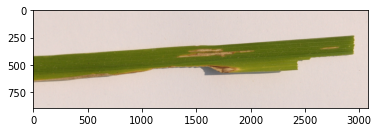

In [9]:
plt.imshow(example_image_arr)

And if we _[slice](https://numpy.org/doc/stable/reference/arrays.indexing.html)_ the array, it is the same as cropping to a sub-image:

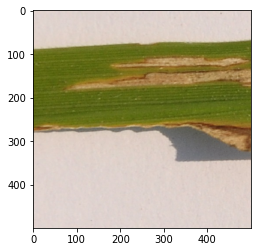

In [10]:
plt.imshow(example_image_arr[250:750, 1250:1750, :]) # Remember the array dimensions are rows,cols,channels

Now, let's do something with that image that lets us take one small step toward being able to classify these diseases.  We will compute a _histogram_ from the image, which essentially counts the number of pixels that contain a range of possible colors.  

To keep the total data size small, we will use a relatively small number of bins (64) for each color channel, which will give us a total of 64*3 = 192 values that represent the image.  (Think of these as _"features"_ extracted from the image.)`

For later use, we can package this up into a function, then apply it to our example image:

In [11]:
def color_histogram(img, n_bins=64):
    '''
    Compute and return the 3-channel histogram for `img`.
    '''
    # Create an array to store the histogram values
    hist_features = np.zeros((n_bins,3))  # 64 bins, 3 color channels
    # For each color channel, compute the histogram and store it:
    for c_idx in range(3):
        hist_features[:,c_idx], hist_edges = np.histogram(
            img[:,:,c_idx], bins=n_bins, range=(0,256)
        )
    hist_features = hist_features / (img.shape[0] * img.shape[1])  # Normalize to the same numeric range for all images
    return hist_features, hist_edges

hist_features, hist_edges = color_histogram(example_image_arr)

Let's have a look at the histogram so that we can see how the "features" relate:

<AxesSubplot:xlabel='Color value', ylabel='Pixel count'>

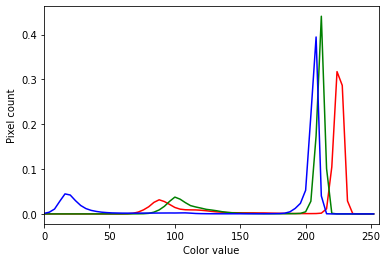

In [12]:
def plot_color_hist(hist_features, hist_edges, ax=None):
    '''
    A function to make it easy to visualize a 3-color histogram
    '''
    if ax is None:
        ax = plt.gca()
    # Use a tuple to store the names of the color 
    # channels:
    colors = ("red", "green", "blue")
    ax.set_xlim([0,256]) # Pixel values are 0-255 in each channel.

    # Create a histogram plot, showing the histogram for each
    # color using a line of the appropriate color.
    for c_idx, color in enumerate(colors):
        ax.plot(hist_edges[:-1], hist_features[:,c_idx], color=color)

    ax.set_xlabel("Color value")
    ax.set_ylabel("Pixel count")
    return ax

plot_color_hist(hist_features, hist_edges)

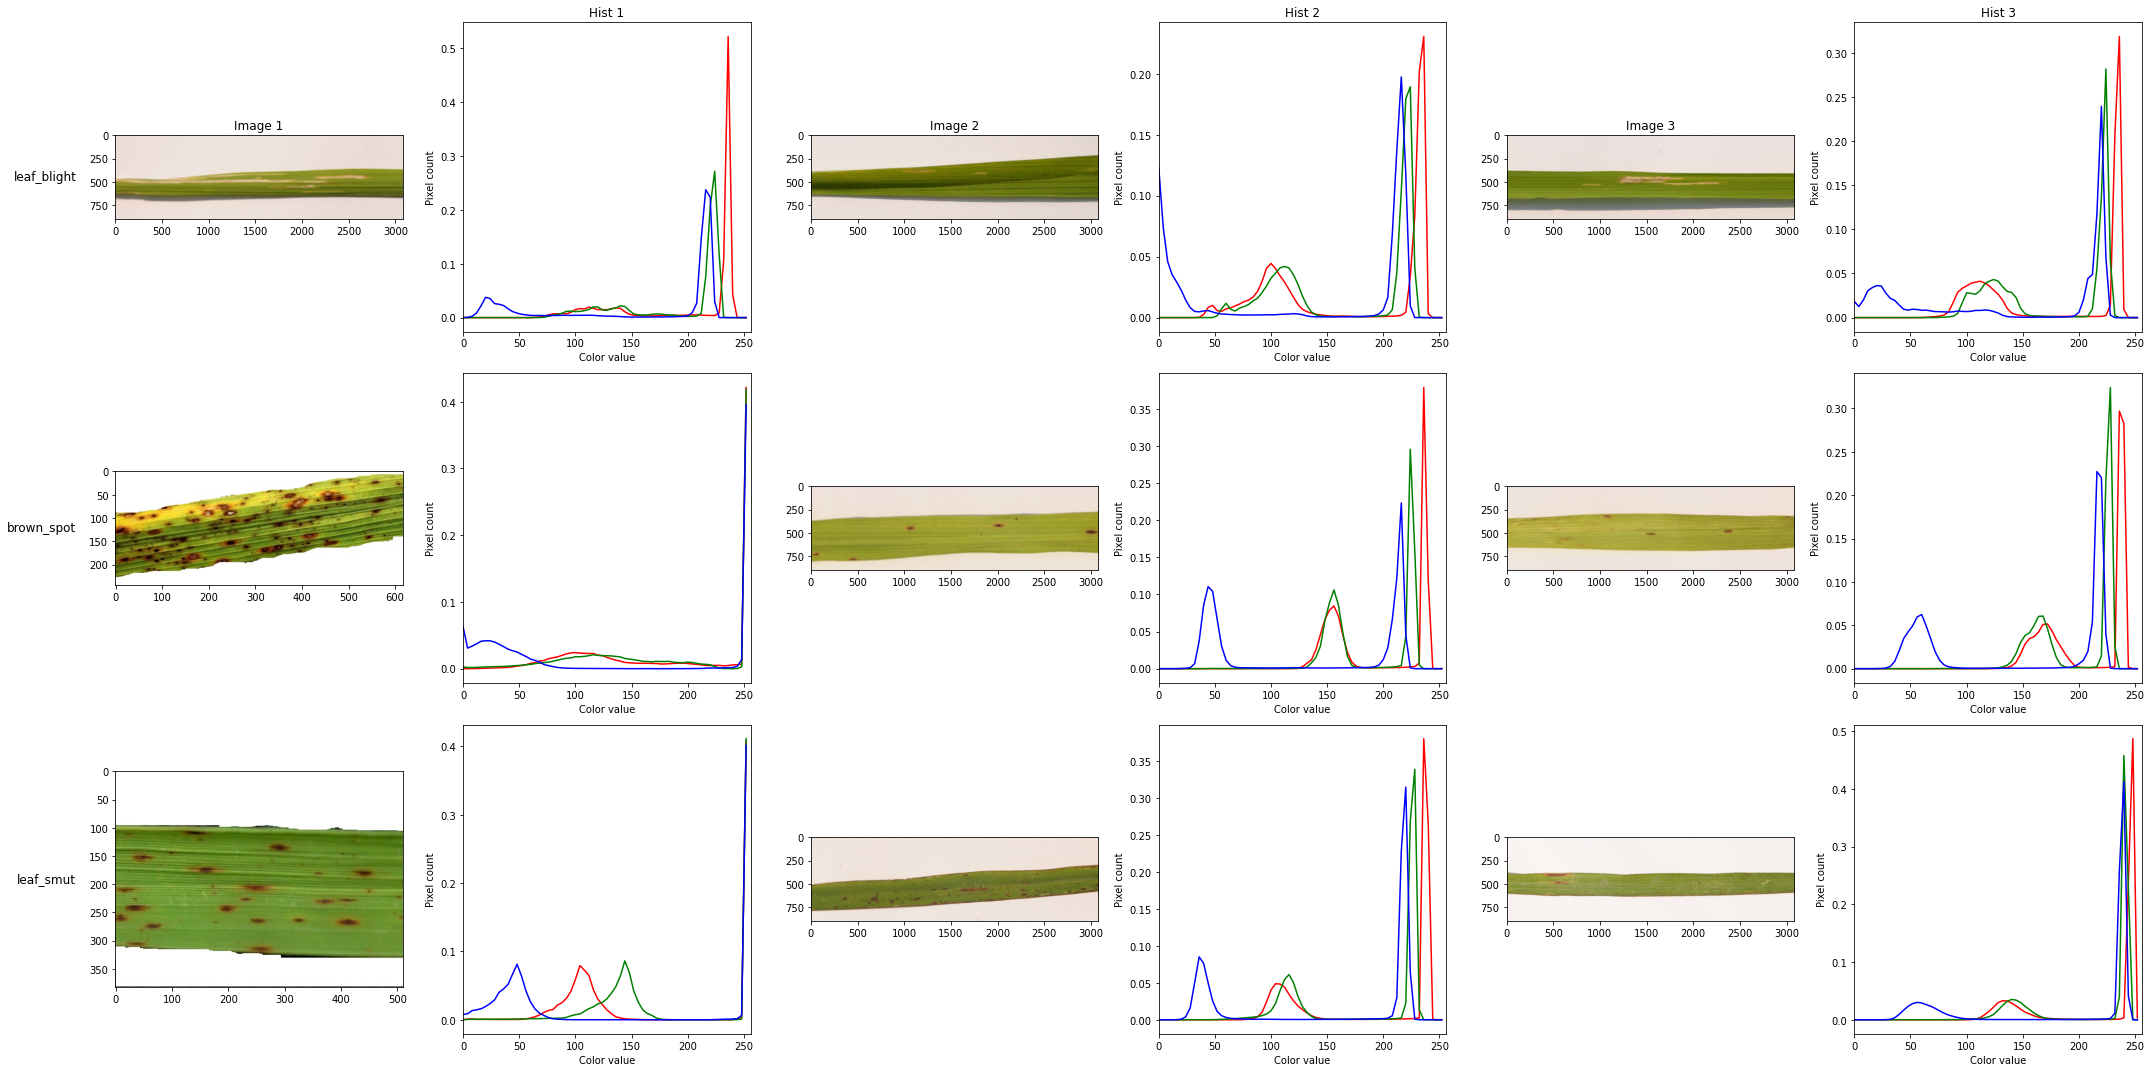

In [13]:
# Let's visualize a few images and histograms from each category:
fig, axes = plt.subplots(3, 6, figsize=(30, 15))
pad = 5
for ax, col in zip(axes[0], ['Image 1', 'Hist 1', 'Image 2', 'Hist 2', 'Image 3', 'Hist 3']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], image_classes):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

for cls_idx, class_name in enumerate(image_classes):
    examples = ground_truth_df[ground_truth_df['class'] == class_name]['image_path'].sample(n=3).values
    img_idx = 0
    for example in examples:
        example_img = plt.imread(example)
        axes[cls_idx, img_idx].imshow(example_img)
        img_idx += 1
        features, edges = color_histogram(example_img)
        axes[cls_idx, img_idx] = plot_color_hist(features, edges, ax=axes[cls_idx, img_idx])
        img_idx += 1


fig.tight_layout()
plt.show()

Can these histograms be used to classify the rice diseases?  Maybe, but probably not well.  There are too many confounding factors, including the background color (some are nearly white, some are black), the zoom level of the leaf (or how many background pixels are present), etc.

Still, it is worth a try.  We can use a Support Vector Classifier from the Scikit-Learn library as a baseline model, with the features arranged as a 1-D array (by placing each color channel histogram after the previous one).

**Before** we can do any model training, we need to split our dataset into a training and a testing set.  This will let us evaluate the performance of the model.  (A cross-validation would be even better, but for now we will use a simple split.)  We will use the StratifiedShuffleSplit from Scikit-Learn to help with this.  It will randomize the data and make sure the test set's class distribution approximately matches the training set.  We will use an 80% (train) / 20% (test) split.

In [14]:
sss = StratifiedShuffleSplit(1, test_size=0.20, random_state=2021)
train_indices, test_indices = list(sss.split(ground_truth_df.values, ground_truth_df['class'].values))[0]
print(f"Training set has {train_indices.shape[0]} samples.")
print(f"Test set has {test_indices.shape[0]} samples.")

Training set has 96 samples.
Test set has 24 samples.


For training, we will need to create an array with the _features_ (X) and the _labels_ (y) for each item in the training set.  The features are the histograms of the images, the class labels are the disease (but we will encode them as integer values 0,1,2).

In [15]:
def image_path_to_features(img_path):
    '''
    Load image, convert to histogram, flatten to 1-D feature array, 
    and return that feature array.
    '''
    img = np.asarray(PIL.Image.open(img_path))
    img_hist, _ = color_histogram(img)
    return img_hist.ravel() # Ravel reduces to 1-D by stacking the color channels one after the other.

class_to_int = {label: idx for idx, label in enumerate(image_classes)}

X_train = []
y_train = []
for idx in train_indices:
    img_path = ground_truth_df.iloc[idx]['image_path']
    img_label = class_to_int[ground_truth_df.iloc[idx]['class']]
    img_hist = image_path_to_features(img_path)
    X_train.append(img_hist)
    y_train.append(img_label)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")


Training X shape: (96, 192)
Training y shape: (96,)


Now, we can train a classifier.  We will use the default paramters for the SVC.

In [16]:
model = SVC()
model.fit(X_train, y_train)

SVC()

The training was easy -- but was it any good?  Let's load up the test data and try some predictions.

We use the same process to load the histograms for the test set, and the labels:

In [17]:
X_test = []
y_test = []
for idx in test_indices:
    img_path = ground_truth_df.iloc[idx]['image_path']
    img_label = class_to_int[ground_truth_df.iloc[idx]['class']]
    img_hist = image_path_to_features(img_path)
    X_test.append(img_hist)
    y_test.append(img_label)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print(f"Testing X shape: {X_test.shape}")
print(f"Testing y shape: {y_test.shape}")

Testing X shape: (24, 192)
Testing y shape: (24,)


Now, we make predictions using the X values (features):

In [18]:
predictions = model.predict(X_test)

We have the predictions.  Let's compare them to the correct labels and show this in a couple of ways.

First, we will create a _confusion matrix_ that compares the predicted label versus the correct label for all classes.  The number of correct predictions are shown along the diagonal; all other numbers are counting incorrect predictions.  (Note:  The Scikit_learn `plot_confusion_matrix` function actually takes the model, variables, and ground truth labels and does the prediction internally.)


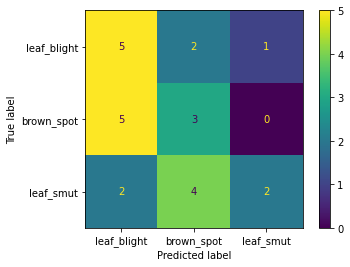

In [19]:
metrics.plot_confusion_matrix(model, X_test, y_test, display_labels=image_classes)

We can tell that the model is not very good -- the numbers off the diagonal are similar in magnitude to the numbers on the diagonal.  This means the model got lots of its predictions wrong.

Again, we expected this just from examining the histogram features.  It might be possible to improve this performance by cleaning the input data further -- removing background pixels and normalizing the intensity levels might be a good place to start.

Let's quantify the performance a bit more with these predictions though:

The `classification_report` from Scikit-Learn shows a lot of information for either binary classification or multi-class classification:

In [20]:
print(metrics.classification_report(y_test, predictions, target_names=image_classes))

              precision    recall  f1-score   support

 leaf_blight       0.42      0.62      0.50         8
  brown_spot       0.33      0.38      0.35         8
   leaf_smut       0.67      0.25      0.36         8

    accuracy                           0.42        24
   macro avg       0.47      0.42      0.41        24
weighted avg       0.47      0.42      0.41        24



We can see that the overall accuracy was 42%.  That means the model got more things wrong than right -- but it also did better than guessing, which would give you about 33% accuracy for three classes.  (We can verify the accuracy by counting the values that were correct in the confusion matrix ($5 + 3 + 2 = 10$) and dividing by the total: $\frac{10}{24} \approx 0.4167 \approx 42\%)$.

For a good discussion of how to calculate and interpret the _precision_, _recall_, and _f1_ metrics, see the Wikipedia article "[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)".

## Go forth and explore!
Now that we've covered the basics of interacting with this dataset, try to reproduce this example yourself "from scratch" to get used to the "feel" of typing in Python code.

Then, try to find a better way to classify these diseases.  Scikit-Learn has many other classification models you could try...  Don't expect great results from using histograms as features, but you might even want to try cleaning the images a bit more as discussed above...

We will take a look at deep learning approaches to this problem soon.